## Emotion Detection

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
import tensorflow as tf
print(tf.__version__)

2.17.0


## Exploring dataset

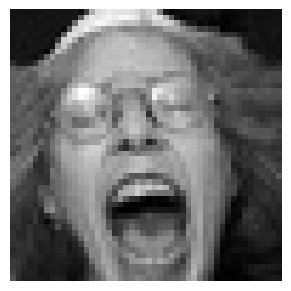

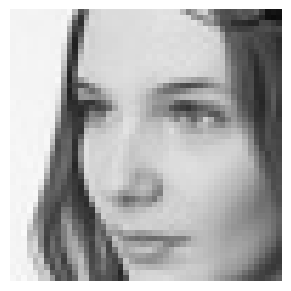

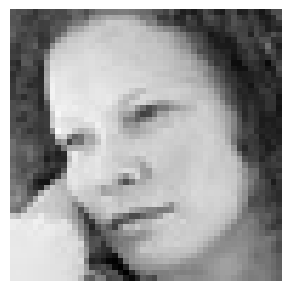

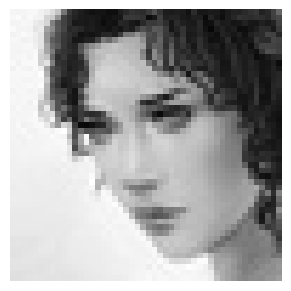

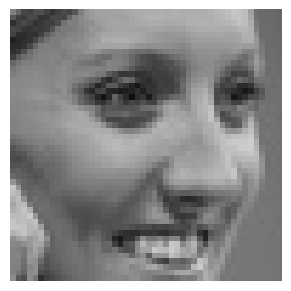

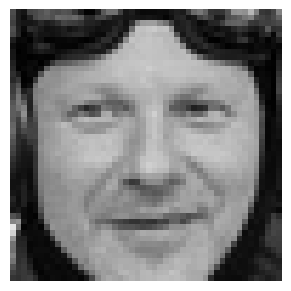

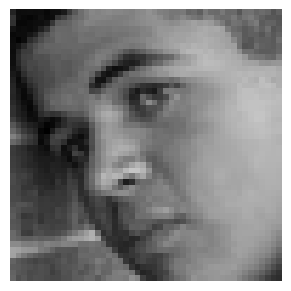

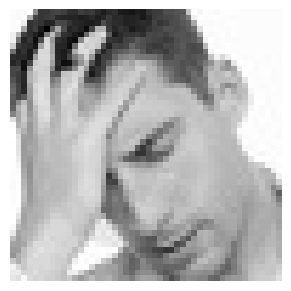

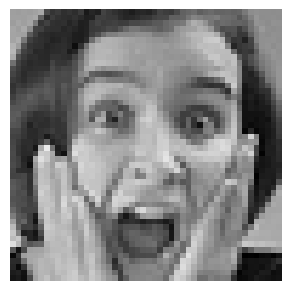

In [2]:
images=glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## preparing data for training

In [3]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/",
                                                target_size=(img_size,img_size),
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

datagen_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/",
                                                target_size=(img_size,img_size),
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Defining the model

In [4]:
def Convolution(input_tensor,filters,kernel_size):
    x=Conv2D(filters=filters,kernel_size=kernel_size,padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    
    return x

In [5]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,32,(3,3))
    conv_2=Convolution(inputs,64,(5,5))
    conv_3=Convolution(inputs,128,(3,3))
    
    flatten=Flatten()(conv_3)
    
    dense_1=Dense_f(flatten,256)
    
    output=Dense(7,activation='softmax')(dense_1)
    
    model=Model(inputs=[inputs],outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    
    return model

In [7]:
model=model_fer((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## Initializing the model

In [8]:
epochs=20
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint('.weights.h5',monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

## Training the model

In [9]:
history=model.fit(x=train_generator,
                 steps_per_epoch=steps_per_epoch,
                 epochs=epochs,
                 validation_data=validation_generator,
                 validation_steps=validation_steps,
                 callbacks=callbacks)

Epoch 1/20


C:\Users\HP\anaconda3\phyton\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3320 - loss: 1.8007
Epoch 1: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.3321 - loss: 1.8004 - val_accuracy: 0.2843 - val_loss: 1.7056
Epoch 2/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:01 541ms/step - accuracy: 0.4375 - loss: 1.5709
Epoch 2: saving model to .weights.h5


C:\Users\HP\anaconda3\phyton\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4375 - loss: 1.5709 - val_accuracy: 0.4000 - val_loss: 1.8864
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4941 - loss: 1.3479
Epoch 3: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.4941 - loss: 1.3479 - val_accuracy: 0.3152 - val_loss: 1.7104
Epoch 4/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 38:01 5s/step - accuracy: 0.4375 - loss: 1.4689
Epoch 4: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4375 - loss: 1.4689 - val_accuracy: 0.4000 - val_loss: 1.7697
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5661 - loss: 1.1782
Epoch 5: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - accuracy: 0.5660 - loss: 1.1783 - val_accuracy: 0.3869 - val_loss: 1.5899
Epoch 6/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 48:44 7s/step - accuracy: 0.6719 - loss: 0.9964
Epoch 6: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 11m

## model evaluation

In [10]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.4333 - loss: 1.9965


[2.0027332305908203, 0.4274170994758606]

## plot loss

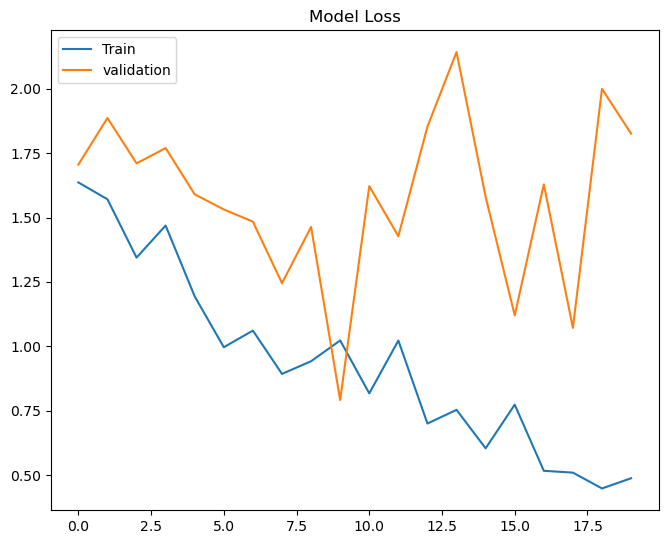

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

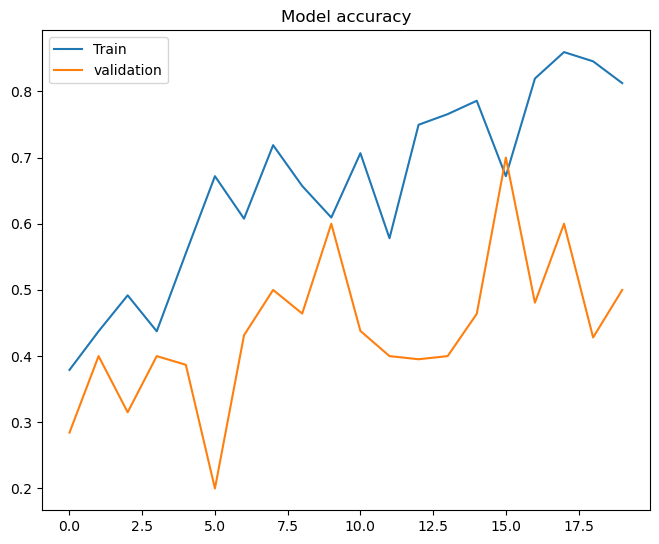

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [14]:
## saving model

model_json=model.to_json()
with open('model_a.json','w') as json_file:
    json_file.write(model_json)